In [1]:
import cftime
import numpy as np
import xarray as xr
import climpred
import proplot as plot
import glob
from tqdm import tqdm
import dask.array as da
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FixedLocator
import math
import warnings
warnings.filterwarnings("ignore")

from dask.distributed import Client
import dask.config
dask.config.set({"array.slicing.split_large_chunks": False})

In [5]:
%pip install git+https://github.com/pangeo-data/climpred.git
    

  Cloning https://github.com/pangeo-data/climpred.git to /glade/scratch/berner/pip-req-build-f1rtuzkd
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Created wheel for climpred: filename=climpred-2.1.3.post8-py2.py3-none-any.whl size=99447 sha256=c45106e55e5f7a3a6cf7232d401d025b3f613a2fa30263b26da589ae7d116d80
  Stored in directory: /glade/scratch/berner/pip-ephem-wheel-cache-x6uxsz9u/wheels/76/ad/d5/00e10a962d441a5e19a9da6435f5e910e1e90244538fd49240
Successfully built climpred
  Attempting uninstall: climpred
    Found existing installation: climpred 2.1.3.post1
    Uninstalling climpred-2.1.3.post1:
      Successfully uninstalled climpred-2.1.3.post1
Note: you may need to restart the kernel to use updated packages.


In [6]:
client = Client("tcp://10.12.1.2:34853")

In [7]:
verifdata = "CPC" #can be ERA5 or CPC
#domain = "global"
domain = "North America"
metric = "rpss" #can be rps, crps, crpss, rmse, acc
if metric == "acc" or metric=="rmse":
    comp="e2o"
    dim="init"
else:
    comp="m2o"
    dim=["init","member"]

In [8]:
hinda2 = xr.open_zarr("/glade/campaign/cesm/development/cross-wg/S2S/jaye/CESM2.S2S.tas_2m.anoms.wklead.zarr/", consolidated=True)
hinda1 = xr.open_zarr("/glade/campaign/cesm/development/cross-wg/S2S/jaye/CESM1.S2S.tas_2m.anoms.wklead.zarr/", consolidated=True)
hindaw = xr.open_zarr("/glade/campaign/cesm/development/cross-wg/S2S/jaye/WACCM.S2S.tas_2m.anoms.wklead.zarr/", consolidated=True)
verif = xr.open_zarr("/glade/campaign/cesm/development/cross-wg/S2S/jaye/"+verifdata+".tas.zarr/", consolidated=True)
#verif = xr.open_dataset("/glade/work/sglanvil/CCR/S2S/data/tas_2m_anom_CPC_sg_s2s_data.nc")
#verif = xr.open_dataset("/glade/scratch/jaye/CPC/tas_2m_anom_CPC_sg_s2s_data.nc")
land = xr.open_dataset("/glade/work/jaye/landsea.nc")

In [9]:
verif

<xarray.Dataset>
Dimensions:    (lat: 181, lon: 360, time: 7670)
Coordinates:
    dayofyear  (time) int64 dask.array<chunksize=(7670,), meta=np.ndarray>
  * lat        (lat) float32 -90.0 -89.0 -88.0 -87.0 ... 87.0 88.0 89.0 90.0
  * lon        (lon) float32 0.0 1.0 2.0 3.0 4.0 ... 356.0 357.0 358.0 359.0
  * time       (time) datetime64[ns] 1999-01-01 1999-01-02 ... 2019-12-31
Data variables:
    TAS        (time, lat, lon) float64 dask.array<chunksize=(130, 181, 360), meta=np.ndarray>

In [10]:
# converting to a proleptic gregorian calendar since the observations
# have leap years. you could also just drop the leap year days from
# the obs.
hinda2["init"] = [cftime.DatetimeProlepticGregorian(d.year, d.month, d.day) for d in hinda2["init"].values]
hinda1["init"] = [cftime.DatetimeProlepticGregorian(d.year, d.month, d.day) for d in hinda1["init"].values]
hindaw["init"] = [cftime.DatetimeProlepticGregorian(d.year, d.month, d.day) for d in hindaw["init"].values]

# designate the lead time step unit.
hinda2["lead"].attrs["units"] = "weeks"
hinda1["lead"].attrs["units"] = "weeks"
hindaw["lead"].attrs["units"] = "weeks"

In [11]:
# Convert our verification product to the same calendar type.
# Climpred just needs to see the same datetime object styles for
# alignment. You could use numpy datestrings or pandas on both,
# cftime.noleap or gregorian, etc.
#def convert_to_cftime(x):
#    x = str(x)
#    y, m, d = x.split("-")
#    y = int(y)
#    m = int(m)
#    d = int(d.split("T")[0])
#    return cftime.DatetimeProlepticGregorian(y, m, d)


#verif["time"] = [convert_to_cftime(t) for t in verif.time.values]

In [12]:
hindaw = hindaw.sel(init=slice("1999-01-01", "2015-12-31"))
hinda1 = hinda1.sel(init=slice("1999-01-01", "2015-12-31"))
hinda2 = hinda2.sel(init=slice("1999-01-01", "2015-12-31"))
verif = verif.sel(time=slice("1999-01-01","2015-12-31"))

In [13]:
#Weird stuff in new zealand happening. This is easiest way to fix that i have found.
if verifdata=="CPC":
    verif = verif.where(-100<verif.TAS)
    verif = verif.where(100>verif.TAS)

In [14]:
verif = verif.isel(lat=slice(0,-1))
hinda2 = hinda2.isel(lat=slice(0,-1))
hinda1 = hinda1.isel(lat=slice(0,-1))
hindaw = hindaw.isel(lat=slice(0,-1))
verif.coords['mask'] = (("lat","lon"),land.LSMASK)
hinda2.coords['mask'] = (("lat","lon"),land.LSMASK)
hinda1.coords['mask'] = (("lat","lon"),land.LSMASK)
hindaw.coords['mask'] = (("lat","lon"),land.LSMASK)

In [15]:
if domain == "North America":
    hinda2 = hinda2.sel(lat=slice(15.0, 75.0))
    hinda2 = hinda2.sel(lon=slice(190.0, 305.0))
    hinda1 = hinda1.sel(lat=slice(15.0, 75.0))
    hinda1 = hinda1.sel(lon=slice(190.0, 305.0))
    hindaw = hindaw.sel(lat=slice(15.0, 75.0))
    hindaw = hindaw.sel(lon=slice(190.0, 305.0))
    verif = verif.sel(lat=slice(15.0, 75.0))
    verif = verif.sel(lon=slice(190.0, 305.0))

In [16]:
hinda2 = hinda2.where(hinda2.mask==1)
hinda1 = hinda1.where(hinda1.mask==1)
hindaw = hindaw.where(hindaw.mask==1)
verif = verif.where(verif.mask==1)

In [17]:
verif = verif.chunk({"time": -1, "lat": "auto", "lon": "auto"}).persist()
hindaw = hindaw.chunk({"member": -1, "init": -1, "lead": "auto", "lat": 36, "lon": 72}).persist()
hinda1 = hinda1.chunk({"member": -1, "init": -1, "lead": "auto", "lat": 36, "lon": 72}).persist()
hinda2 = hinda2.chunk({"member": -1, "init": -1, "lead": "auto", "lat": 36, "lon": 72}).persist()

In [18]:
verifm = verif.resample(time="W-MON").mean()
verifw = verif.resample(time="W-WED").mean()

In [19]:
# Convert our verification product to the same calendar type.
# Climpred just needs to see the same datetime object styles for
# alignment. You could use numpy datestrings or pandas on both,
# cftime.noleap or gregorian, etc.
def convert_to_cftime(x):
    x = str(x)
    y, m, d = x.split("-")
    y = int(y)
    m = int(m)
    d = int(d.split("T")[0])
    return cftime.DatetimeProlepticGregorian(y, m, d)
    #return cftime.DatetimeNoLeap(y, m, d)


verifm["time"] = [convert_to_cftime(t) for t in verifm.time.values]
verifw["time"] = [convert_to_cftime(t) for t in verifw.time.values]

In [20]:
hindaw_djf = hindaw.sel(init=hindaw.init.dt.season=="DJF")
hinda1_djf = hinda1.sel(init=hinda1.init.dt.season=="DJF")
hinda1_jja = hinda1.sel(init=hinda1.init.dt.season=="JJA")
hinda2_djf = hinda2.sel(init=hinda2.init.dt.season=="DJF")
hinda2_jja = hinda2.sel(init=hinda2.init.dt.season=="JJA")
verifm_djf = verifm.sel(time=verifm.time.dt.season=="DJF")
verifm_jja = verifm.sel(time=verifm.time.dt.season=="JJA")
verifw_djf = verifw.sel(time=verifw.time.dt.season=="DJF")
verifw_jja = verifw.sel(time=verifw.time.dt.season=="JJA")

In [21]:
#For WACCM need to do weekly averages starting on monday jan 4 1999. For others, starts on wednesday jan 6 1999

#verif_djf = verif_djf.groupby(verif_djf.time.dt.week).mean("time")
#verif_jja = verif_jja.groupby(verif_jja.time.dt.week).mean("time")
#verif_test = verif_djf.sel(time=verif_djf.time.dt.week=="1")
#verif_djf = verif_djf.resample(time="W-MON").mean()
#verif_jja = verif_jja.resample(time="W-MON").mean()
verifw_djf = verifw_djf.chunk({"time": -1, "lat": "auto", "lon": "auto"}).persist()
verifw_jja = verifw_jja.chunk({"time": -1, "lat": "auto", "lon": "auto"}).persist()
verifm_djf = verifm_djf.chunk({"time": -1, "lat": "auto", "lon": "auto"}).persist()
verifm_jja = verifm_jja.chunk({"time": -1, "lat": "auto", "lon": "auto"}).persist()

In [22]:
hinda1_5_djf = hinda1_djf.sel(member = slice(0,4))
hinda2_5_djf = hinda2_djf.sel(member = slice(0,4))
hinda1_5_jja = hinda1_jja.sel(member = slice(0,4))
hinda2_5_jja = hinda2_jja.sel(member = slice(0,4))

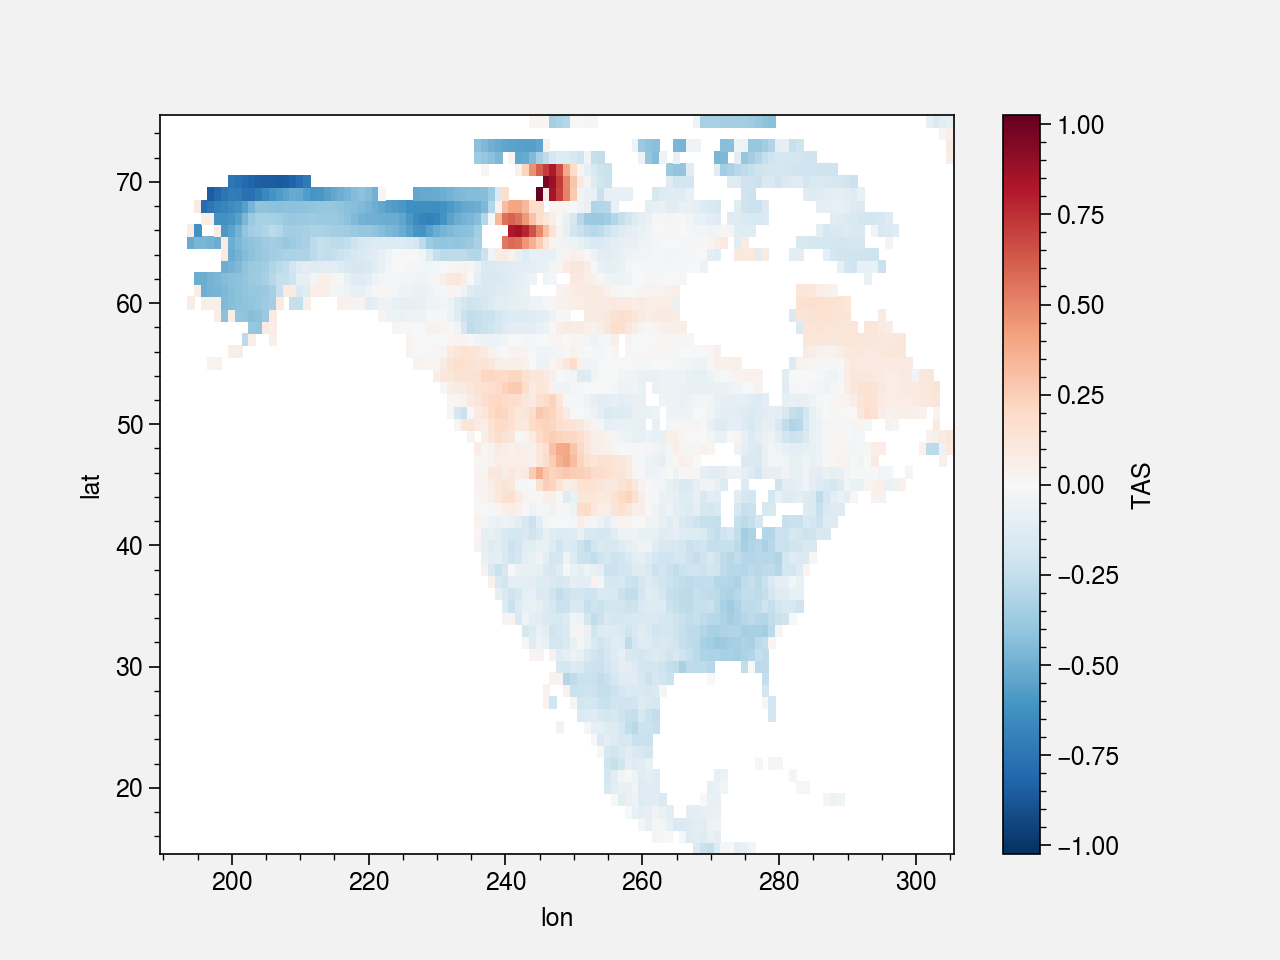

In [23]:
verifw_djf.TAS.mean("time").plot()

In [24]:
#Calculate ensemble spread
#ensprw_djf = hindaw_djf.TAS.std("member").weighted(np.cos(np.deg2rad(hindaw_djf.lat))).mean(("lat","lon")).mean("init")
#enspr1_djf = hinda1_djf.TAS.std("member").weighted(np.cos(np.deg2rad(hinda1_djf.lat))).mean(("lat","lon")).mean("init")
#enspr2_djf = hinda2_djf.TAS.std("member").weighted(np.cos(np.deg2rad(hinda2_djf.lat))).mean(("lat","lon")).mean("init")
#enspr1_5_djf = hinda1_5_djf.TAS.std("member").weighted(np.cos(np.deg2rad(hinda1_5_djf.lat))).mean(("lat","lon")).mean("init")
#enspr2_5_djf = hinda2_5_djf.TAS.std("member").weighted(np.cos(np.deg2rad(hinda2_5_djf.lat))).mean(("lat","lon")).mean("init")
#enspr1_jja = hinda1_jja.TAS.std("member").weighted(np.cos(np.deg2rad(hinda1_jja.lat))).mean(("lat","lon")).mean("init")
#enspr2_jja = hinda2_jja.TAS.std("member").weighted(np.cos(np.deg2rad(hinda2_jja.lat))).mean(("lat","lon")).mean("init")
#enspr1_5_jja = hinda1_5_jja.TAS.std("member").weighted(np.cos(np.deg2rad(hinda1_5_jja.lat))).mean(("lat","lon")).mean("init")
#enspr2_5_jja = hinda2_5_jja.TAS.std("member").weighted(np.cos(np.deg2rad(hinda2_5_jja.lat))).mean(("lat","lon")).mean("init")

In [25]:
hindcastw_djf = climpred.HindcastEnsemble(hindaw_djf).add_observations(verifm_djf)
hindcast1_djf = climpred.HindcastEnsemble(hinda1_djf).add_observations(verifw_djf)
hindcast2_djf = climpred.HindcastEnsemble(hinda2_djf).add_observations(verifm_djf)
hindcast1_5_djf = climpred.HindcastEnsemble(hinda1_5_djf).add_observations(verifw_djf)
hindcast2_5_djf = climpred.HindcastEnsemble(hinda2_5_djf).add_observations(verifm_djf)
hindcast1_jja = climpred.HindcastEnsemble(hinda1_jja).add_observations(verifw_jja)
hindcast2_jja = climpred.HindcastEnsemble(hinda2_jja).add_observations(verifm_jja)
hindcast1_5_jja = climpred.HindcastEnsemble(hinda1_5_jja).add_observations(verifw_jja)
hindcast2_5_jja = climpred.HindcastEnsemble(hinda2_5_jja).add_observations(verifm_jja)

In [26]:
#hinda1_djf_m = hinda1_djf.mean("member")

In [27]:
#hinda1_djf_m = hinda1_djf_m.rename({"init":"time"})

In [28]:
#for w in range(6):
#    test = ((hinda1_djf_m.TAS[:,w,:,:]-verifc_djf.TAS[:,:,:])**2).mean("time")
#    print(w)
#    rmse = np.sqrt(test)
#    #rps1_djf = xr.concat(rmse)
#    #rps1_djf[w,:,:]=np.sqrt(test) #From sasha's matlab code to calculate RMSE

In [29]:
#rps1_djf

In [30]:
#rps1_djf.mean().compute()

In [31]:
hindcastw_djf = hindcastw_djf.smooth({"lead":2})
hindcast1_djf = hindcast1_djf.smooth({"lead":2})
hindcast2_djf = hindcast2_djf.smooth({"lead":2})
hindcast1_5_djf = hindcast1_5_djf.smooth({"lead":2})
hindcast2_5_djf = hindcast2_5_djf.smooth({"lead":2})
hindcast1_jja = hindcast1_jja.smooth({"lead":2})
hindcast2_jja = hindcast2_jja.smooth({"lead":2})
hindcast1_5_jja = hindcast1_5_jja.smooth({"lead":2})
hindcast2_5_jja = hindcast2_5_jja.smooth({"lead":2})
#hindcastw = hindcastw.sel(lead={slice(0,1),slice(2,3),slice(4,5)}).mean("lead").compute()

In [32]:
metric='rps'
binsm_djf = verifm_djf.quantile(q=[.33,.66], dim="time")

In [33]:
# re-chunking since we need time and init to be one chunk for climpred operations.
#hindcastw_djf = hindcastw_djf.chunk({"time": -1, "lat": "auto", "lon": "auto"}).persist()

In [37]:

#rpsw_djf = hindcastw_djf.verify(metric=__rps, comparison=comp, dim=dim, alignment='maximize', category_edges=binsm_djf)
rpsw_djf = hindcastw_djf.verify(metric="rps", comparison=comp, dim=dim, alignment='maximize')#,reference="persistence")

ValueError: require category_edges

In [73]:
rpsw_djf = hindcastw_djf.verify(metric="rmse", comparison=comp, dim=dim, alignment='maximize',reference="climatology")

ValueError: dimension time on 0th function argument to apply_ufunc with dask='parallelized' consists of multiple chunks, but is also a core dimension. To fix, either rechunk into a single dask array chunk along this dimension, i.e., ``.chunk(time: -1)``, or pass ``allow_rechunk=True`` in ``dask_gufunc_kwargs`` but beware that this may significantly increase memory usage.

In [ ]:
rpsw_djf

In [43]:
results = []
# Loops through all inits for a given month.
for label, group in tqdm(hind_aw_reg.groupby("init.month")):
    hindcast = climpred.HindcastEnsemble(group).add_observations(verif_aw_reg)
    skill = hindcast.verify(
        metric="rmse",
        alignment="maximize",
        comparison="e2o",
        dim="init",
        reference="persistence",
    )
    results.append(skill)
results = xr.concat(results, dim="month")

NameError: name 'hind_aw_reg' is not defined

In [40]:
#rpsw_djf = hindcastw_djf.verify(metric=__rps, comparison=comp, dim=dim, alignment='maximize', reference="persistence", category_edges=binsm_djf)

ValueError: Expected to find `member` in `dim`, found ['time']

In [32]:
if metric=="rps":
    #bins = np.array([0.0,0.333,0.666])
    #bins = np.array([-10,-3,3])
    binsw_djf = verifw_djf.quantile(q=[.33,.66], dim="time")
    binsw_jja = verifw_jja.quantile(q=[.33,.66], dim="time")
    binsm_djf = verifm_djf.quantile(q=[.33,.66], dim="time")
    binsm_jja = verifm_jja.quantile(q=[.33,.66], dim="time")
    rpsw_djf = hindcastw_djf.verify(metric=__rps, comparison=comp, dim=dim, alignment='maximize', category_edges=binsm_djf)
    rps1_djf = hindcast1_djf.verify(metric=__rps, comparison=comp, dim=dim, alignment='maximize', category_edges=binsw_djf)
    rps2_djf = hindcast2_djf.verify(metric=__rps, comparison=comp, dim=dim, alignment='maximize', category_edges=binsm_djf)
    rps1_5_djf = hindcast1_5_djf.verify(metric=__rps, comparison=comp, dim=dim, alignment='maximize', category_edges=binsw_djf)
    rps2_5_djf = hindcast2_5_djf.verify(metric=__rps, comparison=comp, dim=dim, alignment='maximize', category_edges=binsm_djf)
    rps1_jja = hindcast1_jja.verify(metric=__rps, comparison=comp, dim=dim, alignment='maximize', category_edges=binsw_jja)
    rps2_jja = hindcast2_jja.verify(metric=__rps, comparison=comp, dim=dim, alignment='maximize', category_edges=binsm_jja)
    rps1_5_jja = hindcast1_5_jja.verify(metric=__rps, comparison=comp, dim=dim, alignment='maximize', category_edges=binsw_jja)
    rps2_5_jja = hindcast2_5_jja.verify(metric=__rps, comparison=comp, dim=dim, alignment='maximize', category_edges=binsm_jja)
else:
    rpsw_djf = hindcastw_djf.verify(metric=metric, comparison=comp, dim=dim, alignment='maximize')
    rps1_djf = hindcast1_djf.verify(metric=metric, comparison=comp, dim=dim, alignment='maximize')
    rps2_djf = hindcast2_djf.verify(metric=metric, comparison=comp, dim=dim, alignment='maximize')
    rps1_5_djf = hindcast1_5_djf.verify(metric=metric, comparison=comp, dim=dim, alignment='maximize')
    rps2_5_djf = hindcast2_5_djf.verify(metric=metric, comparison=comp, dim=dim, alignment='maximize')
    rps1_jja = hindcast1_jja.verify(metric=metric, comparison=comp, dim=dim, alignment='maximize')
    rps2_jja = hindcast2_jja.verify(metric=metric, comparison=comp, dim=dim, alignment='maximize')
    rps1_5_jja = hindcast1_5_jja.verify(metric=metric, comparison=comp, dim=dim, alignment='maximize')
    rps2_5_jja = hindcast2_5_jja.verify(metric=metric, comparison=comp, dim=dim, alignment='maximize')

NameError: name '__rps' is not defined

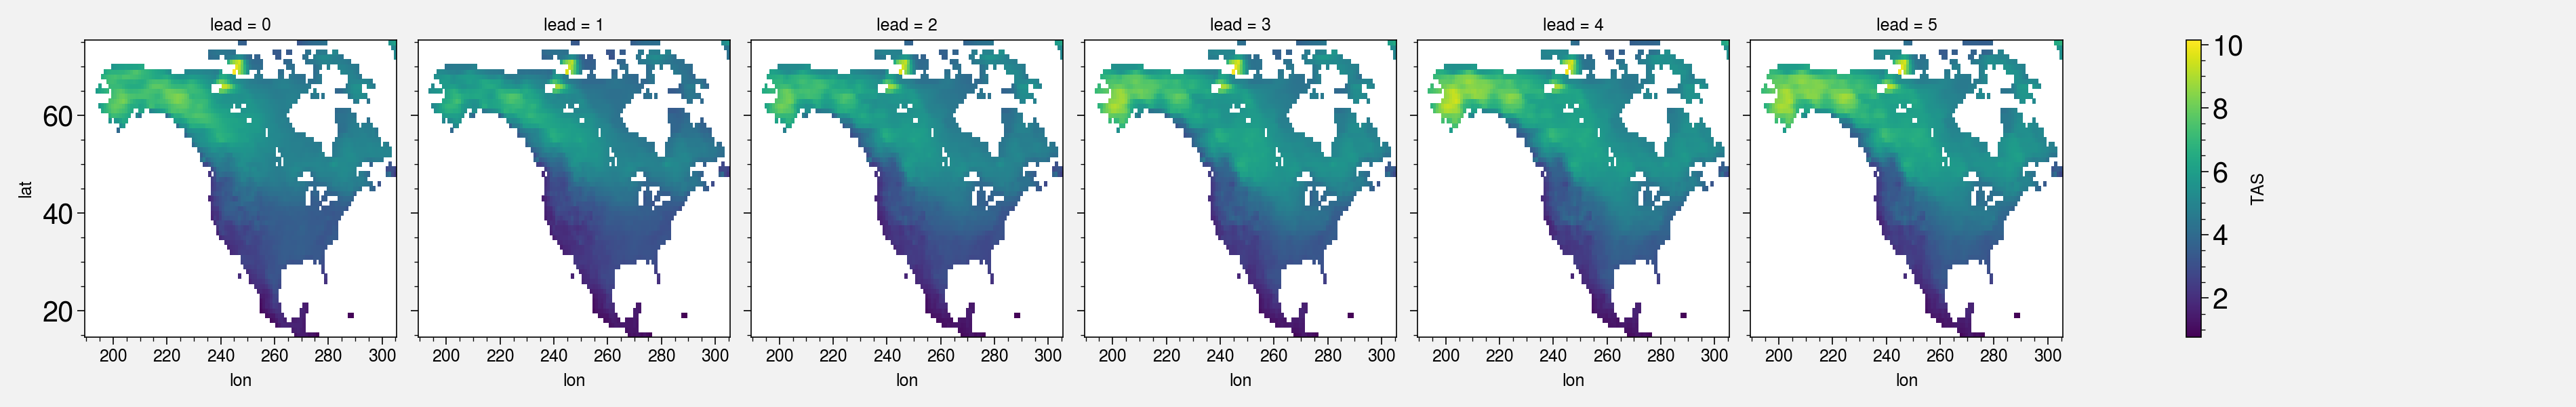

In [130]:
rps2_djf.TAS.sel(lead=slice(0, 6)).plot(col="lead",vmin=0, vmax=10,col_wrap=6)


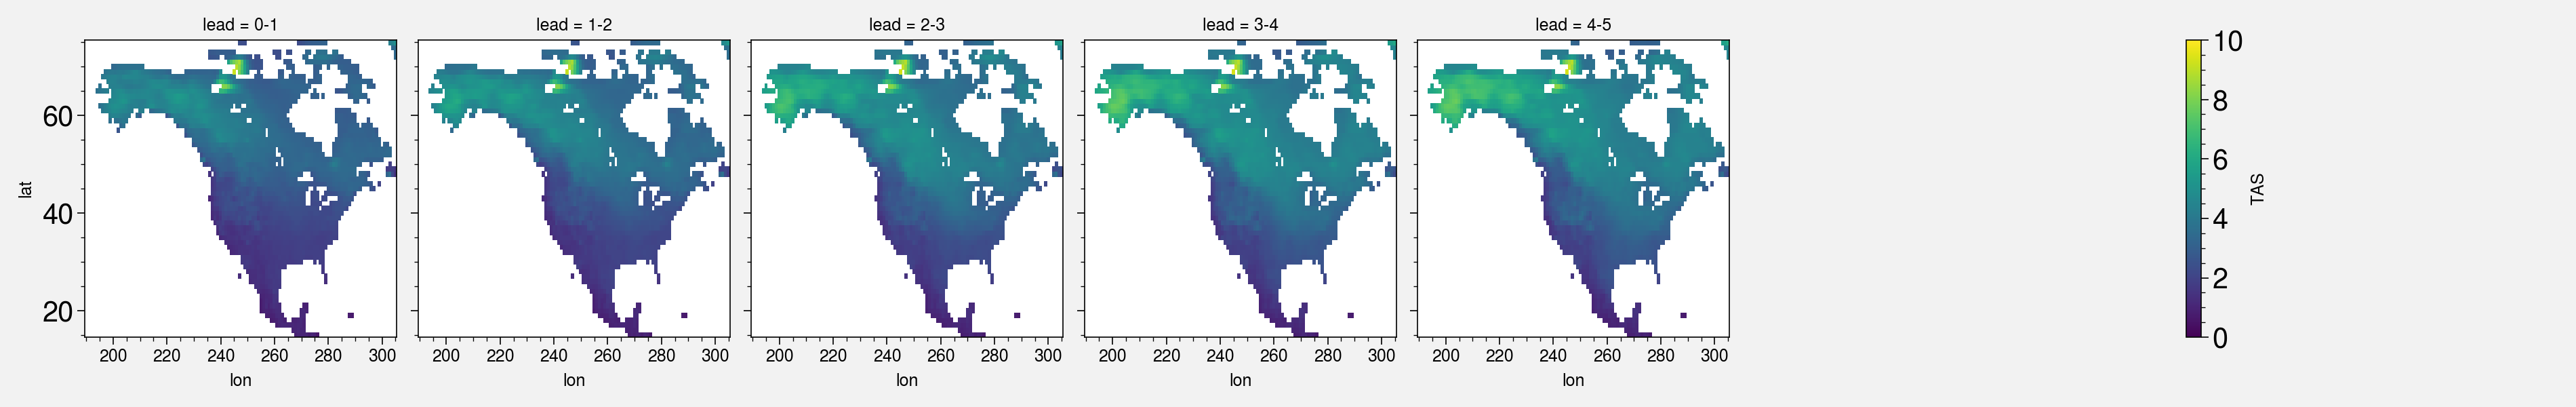

In [159]:
# with smoothing
hindcast2_djf = climpred.HindcastEnsemble(hinda2_djf).add_observations(verifm_djf)
hindcast2_djf = hindcast2_djf.smooth({"lead":2})
rps2_djf = hindcast2_djf.verify(metric=metric, comparison=comp, dim=dim, alignment='maximize')
rps2_djf.TAS.sel(lead=["0-1","1-2","2-3","3-4","4-5"]).plot(col="lead",vmin=0, vmax=10,col_wrap=6)

In [158]:
rps2_djf.TAS

<xarray.DataArray 'TAS' (lead: 5, lat: 61, lon: 116)>
dask.array<concatenate, shape=(5, 61, 116), dtype=float64, chunksize=(1, 36, 72), chunktype=numpy.ndarray>
Coordinates:
  * lead         (lead) <U3 '0-1' '1-2' '2-3' '3-4' '4-5'
  * lat          (lat) float32 15.0 16.0 17.0 18.0 19.0 ... 72.0 73.0 74.0 75.0
  * lon          (lon) float32 190.0 191.0 192.0 193.0 ... 303.0 304.0 305.0
    mask         (lat, lon) int8 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 1 1 1 1
    skill        <U11 'initialized'
    lead_center  (lead) float64 0.5 1.5 2.5 3.5 4.5

In [ ]:
rpsw_djf.TAS.mean(("lat","lon")).compute()

In [ ]:
#rpsw_persistence = climpred.reference.compute_persistence(hindaw_djf,verif_djf,metric='rps',alignment='maximize',add_attrs=True,dim=dim)
#rpsw_persistence = hindcastw_djf.verify(metric=__rps,comparison=comp,reference="persistence",alignment='maximize',dim="init",category_edges=bins_djf)
#crpss1 = 1-crpsw./crpsw_persistence

In [ ]:
#rps2_djf.TAS.sel(lead=slice(4,5)).mean("lead").plot()


In [ ]:
if metric=="rps":
    rpsw_djf = rpsw_djf.where(hindaw.mask==1)
    rps1_djf = rps1_djf.where(hindaw.mask==1)
    rps2_djf = rps2_djf.where(hindaw.mask==1)
    rps1_5_djf = rps1_5_djf.where(hindaw.mask==1)
    rps2_5_djf = rps2_5_djf.where(hindaw.mask==1)
    rps1_jja = rps1_jja.where(hindaw.mask==1)
    rps2_jja = rps2_jja.where(hindaw.mask==1)
    rps1_5_jja = rps1_5_jja.where(hindaw.mask==1)
    rps2_5_jja = rps2_5_jja.where(hindaw.mask==1)
    rpsw_djf = rpsw_djf.where(rpsw_djf.lat>-65.)
    rps1_djf = rps1_djf.where(rps1_djf.lat>-65.)
    rps2_djf = rps2_djf.where(rps2_djf.lat>-65.)
    rps1_5_djf = rps1_5_djf.where(rps1_5_djf.lat>-65.)
    rps2_5_djf = rps2_5_djf.where(rps2_5_djf.lat>-65.)
    rps1_jja = rps1_jja.where(rps1_jja.lat>-65.)
    rps2_jja = rps2_jja.where(rps2_jja.lat>-65.)
    rps1_5_jja = rps1_5_jja.where(rps1_5_jja.lat>-65.)
    rps2_5_jja = rps2_5_jja.where(rps2_5_jja.lat>-65.)
    rps1_jja.TAS.sel(lead="2-3").plot()

In [ ]:
rpsw_djf_aw = rpsw_djf.weighted(np.cos(np.deg2rad(rpsw_djf.lat))).mean(("lat","lon")).compute()
rps1_djf_aw = rps1_djf.weighted(np.cos(np.deg2rad(rps1_djf.lat))).mean(("lat","lon")).compute()
rps2_djf_aw = rps2_djf.weighted(np.cos(np.deg2rad(rps2_djf.lat))).mean(("lat","lon")).compute()
rps1_5_djf_aw = rps1_5_djf.weighted(np.cos(np.deg2rad(rps1_5_djf.lat))).mean(("lat","lon")).compute()
rps2_5_djf_aw = rps2_5_djf.weighted(np.cos(np.deg2rad(rps2_5_djf.lat))).mean(("lat","lon")).compute()
rps1_jja_aw = rps1_jja.weighted(np.cos(np.deg2rad(rps1_djf.lat))).mean(("lat","lon")).compute()
rps2_jja_aw = rps2_jja.weighted(np.cos(np.deg2rad(rps2_djf.lat))).mean(("lat","lon")).compute()
rps1_5_jja_aw = rps1_5_jja.weighted(np.cos(np.deg2rad(rps1_5_djf.lat))).mean(("lat","lon")).compute()
rps2_5_jja_aw = rps2_5_jja.weighted(np.cos(np.deg2rad(rps2_5_djf.lat))).mean(("lat","lon")).compute()

In [ ]:
rps2_djf_aw

In [ ]:
rps2_djf.mean(("lat","lon")).compute()

In [ ]:
barWidth = 0.15
barsw = [rpsw_djf_aw.TAS.sel(lead="0-1"),
         rpsw_djf_aw.TAS.sel(lead="2-3"),
         rpsw_djf_aw.TAS.sel(lead="4-5")]
#barsw = [rpsw_djf_aw.TAS.sel(lead=slice(0,1)).mean("lead").compute(),
#         rpsw_djf_aw.TAS.sel(lead=slice(2,3)).mean("lead").compute(),
#         rpsw_djf_aw.TAS.sel(lead=slice(4,5)).mean("lead").compute()]
rw = np.arange(len(barsw))
bars2_5 = [rps2_5_djf_aw.TAS.sel(lead="0-1"),
           rps2_5_djf_aw.TAS.sel(lead="2-3"),
           rps2_5_djf_aw.TAS.sel(lead="4-5")]
#bars2_5 = [rps2_5_djf_aw.TAS.sel(lead=slice(0,1)).mean("lead").compute(),
#           rps2_5_djf_aw.TAS.sel(lead=slice(2,3)).mean("lead").compute(),
#           rps2_5_djf_aw.TAS.sel(lead=slice(4,5)).mean("lead").compute()]
r2_5 = [x + barWidth + 0.025 for x in rw]
bars2 = [rps2_djf_aw.TAS.sel(lead="0-1"),
         rps2_djf_aw.TAS.sel(lead="2-3"),
         rps2_djf_aw.TAS.sel(lead="4-5")]
#bars2 = [rps2_djf_aw.TAS.sel(lead=slice(0,1)).mean("lead").compute(),
#         rps2_djf_aw.TAS.sel(lead=slice(2,3)).mean("lead").compute(),
#         rps2_djf_aw.TAS.sel(lead=slice(4,5)).mean("lead").compute()]
r2 = [x + barWidth + 0.025 for x in r2_5]
bars1_5 = [rps1_5_djf_aw.TAS.sel(lead="0-1"),
           rps1_5_djf_aw.TAS.sel(lead="2-3"),
           rps1_5_djf_aw.TAS.sel(lead="4-5")]
#bars1_5 = [rps1_5_djf_aw.TAS.sel(lead=slice(0,1)).mean("lead").compute(),
#           rps1_5_djf_aw.TAS.sel(lead=slice(2,3)).mean("lead").compute(),
#           rps1_5_djf_aw.TAS.sel(lead=slice(4,5)).mean("lead").compute()]
r1_5 = [x + barWidth + 0.025 for x in r2]
bars1 = [rps1_djf_aw.TAS.sel(lead="0-1"),
         rps1_djf_aw.TAS.sel(lead="2-3"),
         rps1_djf_aw.TAS.sel(lead="4-5")]
#bars1 = [rps1_djf_aw.TAS.sel(lead=slice(0,1)).mean("lead").compute(),
#         rps1_djf_aw.TAS.sel(lead=slice(2,3)).mean("lead").compute(),
#         rps1_djf_aw.TAS.sel(lead=slice(4,5)).mean("lead").compute()]
r1 = [x + barWidth + 0.025 for x in r1_5]

In [ ]:
plt.bar(rw, barsw, width = barWidth, color = (0, 0.4470, 0.7410), edgecolor="white", label="CESM2-WACCM(5)")
plt.bar(r2_5, bars2_5, width = barWidth, color = (0.6350, 0.0780, 0.1840), alpha=0.4, edgecolor="white", label="CESM2(5)")
plt.bar(r2, bars2, width = barWidth, color = (0.6350, 0.0780, 0.1840), edgecolor="white", label="CESM2(10)")
plt.bar(r1_5, bars1_5, width = barWidth, color = (0.4, .75, 0.1), alpha=0.4, edgecolor="white", label="CESM1(5)")
plt.bar(r1, bars1, width = barWidth, color = (0.4, .75, 0.1), edgecolor="white", label="CESM1(10)")
plt.xticks([r + barWidth + 0.2 for r in range(len(bars1))], ["Weeks 1-2", "Weeks 3-4", "Weeks 5-6"],fontsize=15)
plt.tick_params(axis = "y", direction = "in", which = "both")
plt.tick_params(axis = "y", which = "minor", left = False)
plt.tick_params(axis = "x", which = "both", bottom = False, top = False)
if metric=="acc" or metric=="rps":
    y_locator = FixedLocator([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]) #for rps and acc
    plt.gca().yaxis.set_major_locator(y_locator) #for rps and acc
    plt.ylim(0,1.0) #for rps and acc
#elif metric=="rps":
#    plt.ylim(0,1.5)
elif metric=="crpss":
    plt.ylim(-0.3,0.1) #for crpss
elif metric=="crps":
    plt.ylim(0,6.0) #for crps
elif metric=="rmse":
    plt.ylim(0,6.0) #for rmse
plt.ylabel(metric.upper(),fontsize=15,fontweight="bold")
plt.xlabel("Week",fontsize=15,fontweight="bold")
plt.rc('ytick',labelsize=15)
#plt.title("2m Temperature "+metric.upper()+" for "+domain+" land (DJF)")
#plt.legend(borderaxespad=0.6,edgecolor="black",prop={'size': 14})
if domain == "North America":
    #plt.text(-0.15,0.93,"(b)",size=15,fontweight="bold")
    plt.text(-0.15,5.6,"(b)",size=15,fontweight="bold")
    plt.title("North America Land",fontsize=15,fontweight="bold")
    #plt.savefig(metric+"_NAland_DJF_"+verifdata+".jpg",dpi=300,bbox_inches="tight")
elif domain == "global":
    #plt.text(-0.15,0.93,"(a)",size=15,fontweight="bold")
    plt.text(-0.15,5.6,"(a)",size=15,fontweight="bold")
    plt.title("Global Land",fontsize=15,fontweight='bold')
    plt.legend(borderaxespad=0.6,edgecolor="black",prop={'size': 15})
    #plt.savefig(metric+"_globalland_DJF_"+verifdata+".jpg",dpi=300,bbox_inches="tight")

In [ ]:
barWidth = 0.175
#bars2_5 = [rps2_5_jja_aw.TAS.sel(lead=slice(0,1)).mean("lead").persist(),
#           rps2_5_jja_aw.TAS.sel(lead=slice(2,3)).mean("lead").persist(),
#           rps2_5_jja_aw.TAS.sel(lead=slice(4,5)).mean("lead").persist()]
bars2_5 = [rps2_5_jja_aw.TAS.sel(lead="0-1"),
           rps2_5_jja_aw.TAS.sel(lead="2-3"),
           rps2_5_jja_aw.TAS.sel(lead="4-5")]
r2_5 = np.arange(len(bars2_5))
#bars2 = [rps2_jja_aw.TAS.sel(lead=slice(0,1)).mean("lead").persist(),
#         rps2_jja_aw.TAS.sel(lead=slice(2,3)).mean("lead").persist(),
#         rps2_jja_aw.TAS.sel(lead=slice(4,5)).mean("lead").persist()]
bars2 = [rps2_jja_aw.TAS.sel(lead="0-1"),
         rps2_jja_aw.TAS.sel(lead="2-3"),
         rps2_jja_aw.TAS.sel(lead="4-5")]
r2 = [x + barWidth + 0.025 for x in r2_5]
#bars1_5 = [rps1_5_jja_aw.TAS.sel(lead=slice(0,1)).mean("lead").persist(),
#           rps1_5_jja_aw.TAS.sel(lead=slice(2,3)).mean("lead").persist(),
#           rps1_5_jja_aw.TAS.sel(lead=slice(4,5)).mean("lead").persist()]
bars1_5 = [rps1_5_jja_aw.TAS.sel(lead="0-1"),
           rps1_5_jja_aw.TAS.sel(lead="2-3"),
           rps1_5_jja_aw.TAS.sel(lead="4-5")]
r1_5 = [x + barWidth + 0.025 for x in r2]
#bars1 = [rps1_jja_aw.TAS.sel(lead=slice(0,1)).mean("lead").persist(),
#         rps1_jja_aw.TAS.sel(lead=slice(2,3)).mean("lead").persist(),
#         rps1_jja_aw.TAS.sel(lead=slice(4,5)).mean("lead").persist()]
bars1 = [rps1_jja_aw.TAS.sel(lead="0-1"),
         rps1_jja_aw.TAS.sel(lead="2-3"),
         rps1_jja_aw.TAS.sel(lead="4-5")]
r1 = [x + barWidth + 0.025 for x in r1_5]

In [ ]:
plt.bar(r2_5, bars2_5, width = barWidth, color = (0.6350, 0.0780, 0.1840), alpha=0.4, edgecolor="white", label="CESM2(5)")
plt.bar(r2, bars2, width = barWidth, color = (0.6350, 0.0780, 0.1840), edgecolor="white", label="CESM2(10)")
plt.bar(r1_5, bars1_5, width = barWidth, color = (0.4, .75, 0.1), alpha=0.4, edgecolor="white", label="CESM1(5)")
plt.bar(r1, bars1, width = barWidth, color = (0.4, .75, 0.1), edgecolor="white", label="CESM1(10)")
plt.xticks([r + barWidth + 0.125 for r in range(len(bars1))], ["Weeks 1-2", "Weeks 3-4", "Weeks 5-6"],fontsize=15)
plt.tick_params(axis = "y", direction = "in", which = "both")
plt.tick_params(axis = "y", which = "minor", left = False)
plt.tick_params(axis = "x", which = "both", bottom = False, top = False)
if metric=="acc" or metric=="rps":
    y_locator = FixedLocator([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]) #for rps and acc
    plt.gca().yaxis.set_major_locator(y_locator) #for rps and acc
    plt.ylim(0,1.0) #for rps and acc
#elif metric=="rps":
#    plt.ylim(0,1.5)
elif metric=="crpss":
    plt.ylim(-0.3,0.1) #for crpss
elif metric=="crps":
    plt.ylim(0,6.0) #for crps
elif metric=="rmse":
    plt.ylim(0,6.0) #for rmse
plt.ylabel(metric.upper(),fontsize=15,fontweight="bold")
plt.xlabel("Week",fontsize=15,fontweight="bold")
plt.rc('ytick',labelsize=15)
#plt.title("2m Temperature "+metric.upper()+" for "+domain+" land (JJA)")
#plt.legend(borderaxespad=0.6,edgecolor="black",prop={'size': 14})
if domain == "North America":
    #plt.text(-0.15,0.93,"(b)",size=15,fontweight="bold")
    plt.text(-0.15,5.6,"(b)",size=15,fontweight="bold")
    plt.title("North America Land",fontsize=15,fontweight="bold")
    plt.savefig(metric+"_NAland_JJA_"+verifdata+".jpg",dpi=300,bbox_inches="tight")
elif domain == "global":
    #plt.text(-0.15,0.93,"(a)",size=15,fontweight="bold")
    plt.text(-0.15,5.6,"(a)",size=15,fontweight="bold")
    plt.title("Global Land",fontsize=15,fontweight='bold')
    plt.legend(borderaxespad=0.6,edgecolor="black",prop={'size': 15})
    plt.savefig(metric+"_globalland_JJA_"+verifdata+".jpg",dpi=300,bbox_inches="tight")

Bar plots for with both ensemble spread and rmse

In [ ]:
barWidth = 0.067
#barsw = [rpsw_djf_aw.TAS.sel(lead=slice(0,1)).mean("lead").compute(),
#         rpsw_djf_aw.TAS.sel(lead=slice(2,3)).mean("lead").compute(),
#         rpsw_djf_aw.TAS.sel(lead=slice(4,5)).mean("lead").compute()]
barsw = [rpsw_djf_aw.TAS.sel(lead="0-1"),
         rpsw_djf_aw.TAS.sel(lead="2-3"),
         rpsw_djf_aw.TAS.sel(lead="4-5")]
rw = np.arange(len(barsw))
#barsw_s = [ensprw_djf.sel(lead=slice(0,1)).mean("lead").compute(),
#           ensprw_djf.sel(lead=slice(2,3)).mean("lead").compute(),
#           ensprw_djf.sel(lead=slice(4,5)).mean("lead").compute()]
barsw_s = [hindaw_djf.sel(lead=slice(0,1)).mean("lead").TAS.std("member").weighted(np.cos(np.deg2rad(hindaw_djf.lat))).mean(("lat","lon")).mean("init").compute(),
           hindaw_djf.sel(lead=slice(2,3)).mean("lead").TAS.std("member").weighted(np.cos(np.deg2rad(hindaw_djf.lat))).mean(("lat","lon")).mean("init").compute(),
           hindaw_djf.sel(lead=slice(4,5)).mean("lead").TAS.std("member").weighted(np.cos(np.deg2rad(hindaw_djf.lat))).mean(("lat","lon")).mean("init").compute()]
rw_s = [x + barWidth + 0.025 for x in rw]
#bars2_5 = [rps2_5_djf_aw.TAS.sel(lead=slice(0,1)).mean("lead").compute(),
#           rps2_5_djf_aw.TAS.sel(lead=slice(2,3)).mean("lead").compute(),
#           rps2_5_djf_aw.TAS.sel(lead=slice(4,5)).mean("lead").compute()]
bars2_5 = [rps2_5_djf_aw.TAS.sel(lead="0-1"),
           rps2_5_djf_aw.TAS.sel(lead="2-3"),
           rps2_5_djf_aw.TAS.sel(lead="4-5")]
r2_5 = [x + barWidth + 0.025 for x in rw_s]
#bars2_5_s = [enspr2_5_djf.sel(lead=slice(0,1)).mean("lead").compute(),
#           enspr2_5_djf.sel(lead=slice(2,3)).mean("lead").compute(),
#           enspr2_5_djf.sel(lead=slice(4,5)).mean("lead").compute()]
bars2_5_s = [hinda2_5_djf.sel(lead=slice(0,1)).mean("lead").TAS.std("member").weighted(np.cos(np.deg2rad(hinda2_5_djf.lat))).mean(("lat","lon")).mean("init").compute(),
             hinda2_5_djf.sel(lead=slice(2,3)).mean("lead").TAS.std("member").weighted(np.cos(np.deg2rad(hinda2_5_djf.lat))).mean(("lat","lon")).mean("init").compute(),
             hinda2_5_djf.sel(lead=slice(4,5)).mean("lead").TAS.std("member").weighted(np.cos(np.deg2rad(hinda2_5_djf.lat))).mean(("lat","lon")).mean("init").compute()]
r2_5_s = [x + barWidth + 0.025 for x in r2_5]
#bars2 = [rps2_djf_aw.TAS.sel(lead=slice(0,1)).mean("lead").compute(),
#         rps2_djf_aw.TAS.sel(lead=slice(2,3)).mean("lead").compute(),
#         rps2_djf_aw.TAS.sel(lead=slice(4,5)).mean("lead").compute()]
bars2 = [rps2_djf_aw.TAS.sel(lead="0-1"),
         rps2_djf_aw.TAS.sel(lead="2-3"),
         rps2_djf_aw.TAS.sel(lead="4-5")]
r2 = [x + barWidth + 0.025 for x in r2_5_s]
#bars2_s = [enspr2_djf.sel(lead=slice(0,1)).mean("lead").compute(),
#           enspr2_djf.sel(lead=slice(2,3)).mean("lead").compute(),
#           enspr2_djf.sel(lead=slice(4,5)).mean("lead").compute()]
bars2_s = [hinda2_djf.sel(lead=slice(0,1)).mean("lead").TAS.std("member").weighted(np.cos(np.deg2rad(hinda2_djf.lat))).mean(("lat","lon")).mean("init").compute(),
            hinda2_djf.sel(lead=slice(2,3)).mean("lead").TAS.std("member").weighted(np.cos(np.deg2rad(hinda2_djf.lat))).mean(("lat","lon")).mean("init").compute(),
            hinda2_djf.sel(lead=slice(4,5)).mean("lead").TAS.std("member").weighted(np.cos(np.deg2rad(hinda2_djf.lat))).mean(("lat","lon")).mean("init").compute()]
r2_s = [x + barWidth + 0.025 for x in r2]
#bars1_5 = [rps1_5_djf_aw.TAS.sel(lead=slice(0,1)).mean("lead").compute(),
#           rps1_5_djf_aw.TAS.sel(lead=slice(2,3)).mean("lead").compute(),
#           rps1_5_djf_aw.TAS.sel(lead=slice(4,5)).mean("lead").compute()]
bars1_5 = [rps1_5_djf_aw.TAS.sel(lead="0-1"),
           rps1_5_djf_aw.TAS.sel(lead="2-3"),
           rps1_5_djf_aw.TAS.sel(lead="4-5")]
r1_5 = [x + barWidth + 0.025 for x in r2_s]
#bars1_5_s = [enspr1_5_djf.sel(lead=slice(0,1)).mean("lead").compute(),
#             enspr1_5_djf.sel(lead=slice(2,3)).mean("lead").compute(),
#             enspr1_5_djf.sel(lead=slice(4,5)).mean("lead").compute()]
bars1_5_s = [hinda1_5_djf.sel(lead=slice(0,1)).mean("lead").TAS.std("member").weighted(np.cos(np.deg2rad(hinda1_5_djf.lat))).mean(("lat","lon")).mean("init").compute(),
             hinda1_5_djf.sel(lead=slice(2,3)).mean("lead").TAS.std("member").weighted(np.cos(np.deg2rad(hinda1_5_djf.lat))).mean(("lat","lon")).mean("init").compute(),
             hinda1_5_djf.sel(lead=slice(4,5)).mean("lead").TAS.std("member").weighted(np.cos(np.deg2rad(hinda1_5_djf.lat))).mean(("lat","lon")).mean("init").compute()]
r1_5_s = [x + barWidth + 0.025 for x in r1_5]
#bars1 = [rps1_djf_aw.TAS.sel(lead=slice(0,1)).mean("lead").compute(),
#         rps1_djf_aw.TAS.sel(lead=slice(2,3)).mean("lead").compute(),
#         rps1_djf_aw.TAS.sel(lead=slice(4,5)).mean("lead").compute()]
bars1 = [rps1_djf_aw.TAS.sel(lead="0-1"),
         rps1_djf_aw.TAS.sel(lead="2-3"),
         rps1_djf_aw.TAS.sel(lead="4-5")]
r1 = [x + barWidth + 0.025 for x in r1_5_s]
#bars1_s = [enspr1_djf.sel(lead=slice(0,1)).mean("lead").compute(),
#           enspr1_djf.sel(lead=slice(2,3)).mean("lead").compute(),
#           enspr1_djf.sel(lead=slice(4,5)).mean("lead").compute()]
bars1_s = [hinda1_djf.sel(lead=slice(0,1)).mean("lead").TAS.std("member").weighted(np.cos(np.deg2rad(hinda1_djf.lat))).mean(("lat","lon")).mean("init").compute(),
           hinda1_djf.sel(lead=slice(2,3)).mean("lead").TAS.std("member").weighted(np.cos(np.deg2rad(hinda1_djf.lat))).mean(("lat","lon")).mean("init").compute(),
           hinda1_djf.sel(lead=slice(4,5)).mean("lead").TAS.std("member").weighted(np.cos(np.deg2rad(hinda1_djf.lat))).mean(("lat","lon")).mean("init").compute()]
r1_s = [x + barWidth + 0.025 for x in r1]

In [ ]:
plt.bar(rw, barsw, width = barWidth, color = (0, 0.4470, 0.7410), edgecolor="white", label="CESM2-WACCM(5)")
plt.bar(rw_s, barsw_s, width = barWidth, color = (0, 0.4470, 0.7410), edgecolor="white", hatch="///")
plt.bar(r2_5, bars2_5, width = barWidth, color = (0.6350, 0.0780, 0.1840), alpha=0.4, edgecolor="white", label="CESM2(5)")
plt.bar(r2_5_s, bars2_5_s, width = barWidth, color = (0.6350, 0.0780, 0.1840), alpha=0.4, edgecolor="white", hatch="///")
plt.bar(r2, bars2, width = barWidth, color = (0.6350, 0.0780, 0.1840), edgecolor="white", label="CESM2(10)")
plt.bar(r2_s, bars2_s, width = barWidth, color = (0.6350, 0.0780, 0.1840), edgecolor="white", hatch="///")
plt.bar(r1_5, bars1_5, width = barWidth, color = (0.4, .75, 0.1), alpha=0.4, edgecolor="white", label="CESM1(5)")
plt.bar(r1_5_s, bars1_5_s, width = barWidth, color = (0.4, .75, 0.1), alpha=0.4, edgecolor="white", hatch="///")
plt.bar(r1, bars1, width = barWidth, color = (0.4, .75, 0.1), edgecolor="white", label="CESM1(10)")
plt.bar(r1_s, bars1_s, width = barWidth, color = (0.4, .75, 0.1), edgecolor="white", hatch="///")
plt.xticks([r + barWidth + 0.3475 for r in range(len(bars1))], ["Weeks 1-2", "Weeks 3-4", "Weeks 5-6"],fontsize=15)
plt.tick_params(axis = "y", direction = "in", which = "both")
plt.tick_params(axis = "y", which = "minor", left = False)
plt.tick_params(axis = "x", which = "both", bottom = False, top = False)
if metric=="acc":
    y_locator = FixedLocator([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]) #for rps and acc
    plt.gca().yaxis.set_major_locator(y_locator) #for rps and acc
    plt.ylim(0,1.0) #for rps and acc
elif metric=="rps":
    plt.ylim(0,1.5)
elif metric=="crpss":
    plt.ylim(-0.3,0.1) #for crpss
elif metric=="crps":
    plt.ylim(0,6.0) #for crps
elif metric=="rmse":
    plt.ylim(0,6.0) #for rmse
plt.ylabel(metric.upper()+" and Spread (hatched)",fontsize=15,fontweight="bold")
plt.xlabel("Week",fontsize=15,fontweight="bold")
plt.rc('ytick',labelsize=15)
#plt.title("2m Temperature "+metric.upper()+" and ensemble spread for "+domain+" land (DJF)")
#plt.legend(borderaxespad=0.6,edgecolor="black",prop={'size': 14})
if domain == "North America":
    plt.text(-0.1,5.6,"(b)",size=15,fontweight="bold")
    plt.title("North America Land",fontsize=15,fontweight="bold")
    plt.savefig(metric+"_spread_NAland_DJF_"+verifdata+".jpg",dpi=300,bbox_inches="tight")
elif domain == "global":
    plt.text(-0.1,5.6,"(a)",size=15,fontweight="bold")
    plt.title("Global Land",fontsize=15,fontweight='bold')
    plt.legend(borderaxespad=0.6,edgecolor="black",prop={'size': 15})
    plt.savefig(metric+"_spread_globalland_DJF_"+verifdata+".jpg",dpi=300,bbox_inches="tight")

In [ ]:
barWidth = 0.085
#bars2_5 = [rps2_5_jja_aw.TAS.sel(lead=slice(0,1)).mean("lead").compute(),
#           rps2_5_jja_aw.TAS.sel(lead=slice(2,3)).mean("lead").compute(),
#           rps2_5_jja_aw.TAS.sel(lead=slice(4,5)).mean("lead").compute()]
bars2_5 = [rps2_5_jja_aw.TAS.sel(lead="0-1"),
           rps2_5_jja_aw.TAS.sel(lead="2-3"),
           rps2_5_jja_aw.TAS.sel(lead="4-5")]
r2_5 = np.arange(len(bars2_5))
#bars2_5_s = [enspr2_5_jja.sel(lead=slice(0,1)).mean("lead").compute(),
#             enspr2_5_jja.sel(lead=slice(2,3)).mean("lead").compute(),
#             enspr2_5_jja.sel(lead=slice(4,5)).mean("lead").compute()]
bars2_5_s = [hinda2_5_jja.sel(lead=slice(0,1)).mean("lead").TAS.std("member").weighted(np.cos(np.deg2rad(hinda2_5_jja.lat))).mean(("lat","lon")).mean("init").compute(),
             hinda2_5_jja.sel(lead=slice(2,3)).mean("lead").TAS.std("member").weighted(np.cos(np.deg2rad(hinda2_5_jja.lat))).mean(("lat","lon")).mean("init").compute(),
             hinda2_5_jja.sel(lead=slice(4,5)).mean("lead").TAS.std("member").weighted(np.cos(np.deg2rad(hinda2_5_jja.lat))).mean(("lat","lon")).mean("init").compute()]
r2_5_s = [x + barWidth + 0.025 for x in r2_5]
#bars2 = [rps2_jja_aw.TAS.sel(lead=slice(0,1)).mean("lead").compute(),
#         rps2_jja_aw.TAS.sel(lead=slice(2,3)).mean("lead").compute(),
#         rps2_jja_aw.TAS.sel(lead=slice(4,5)).mean("lead").compute()]
bars2 = [rps2_jja_aw.TAS.sel(lead="0-1"),
         rps2_jja_aw.TAS.sel(lead="2-3"),
         rps2_jja_aw.TAS.sel(lead="4-5")]
r2 = [x + barWidth + 0.025 for x in r2_5_s]
#bars2_s = [enspr2_jja.sel(lead=slice(0,1)).mean("lead").compute(),
#           enspr2_jja.sel(lead=slice(2,3)).mean("lead").compute(),
#           enspr2_jja.sel(lead=slice(4,5)).mean("lead").compute()]
bars2_s = [hinda2_jja.sel(lead=slice(0,1)).mean("lead").TAS.std("member").weighted(np.cos(np.deg2rad(hinda2_jja.lat))).mean(("lat","lon")).mean("init").compute(),
           hinda2_jja.sel(lead=slice(2,3)).mean("lead").TAS.std("member").weighted(np.cos(np.deg2rad(hinda2_jja.lat))).mean(("lat","lon")).mean("init").compute(),
           hinda2_jja.sel(lead=slice(4,5)).mean("lead").TAS.std("member").weighted(np.cos(np.deg2rad(hinda2_jja.lat))).mean(("lat","lon")).mean("init").compute()]
r2_s = [x + barWidth + 0.025 for x in r2]
#bars1_5 = [rps1_5_jja_aw.TAS.sel(lead=slice(0,1)).mean("lead").compute(),
#           rps1_5_jja_aw.TAS.sel(lead=slice(2,3)).mean("lead").compute(),
#           rps1_5_jja_aw.TAS.sel(lead=slice(4,5)).mean("lead").compute()]
bars1_5 = [rps1_5_jja_aw.TAS.sel(lead="0-1"),
           rps1_5_jja_aw.TAS.sel(lead="2-3"),
           rps1_5_jja_aw.TAS.sel(lead="4-5")]
r1_5 = [x + barWidth + 0.025 for x in r2_s]
#bars1_5_s = [enspr1_5_jja.sel(lead=slice(0,1)).mean("lead").compute(),
#             enspr1_5_jja.sel(lead=slice(2,3)).mean("lead").compute(),
#             enspr1_5_jja.sel(lead=slice(4,5)).mean("lead").compute()]
bars1_5_s = [hinda1_5_jja.sel(lead=slice(0,1)).mean("lead").TAS.std("member").weighted(np.cos(np.deg2rad(hinda1_5_jja.lat))).mean(("lat","lon")).mean("init").compute(),
             hinda1_5_jja.sel(lead=slice(2,3)).mean("lead").TAS.std("member").weighted(np.cos(np.deg2rad(hinda1_5_jja.lat))).mean(("lat","lon")).mean("init").compute(),
             hinda1_5_jja.sel(lead=slice(4,5)).mean("lead").TAS.std("member").weighted(np.cos(np.deg2rad(hinda1_5_jja.lat))).mean(("lat","lon")).mean("init").compute()]
r1_5_s = [x + barWidth + 0.025 for x in r1_5]
#bars1 = [rps1_jja_aw.TAS.sel(lead=slice(0,1)).mean("lead").compute(),
#         rps1_jja_aw.TAS.sel(lead=slice(2,3)).mean("lead").compute(),
#         rps1_jja_aw.TAS.sel(lead=slice(4,5)).mean("lead").compute()]
bars1 = [rps1_jja_aw.TAS.sel(lead="0-1"),
         rps1_jja_aw.TAS.sel(lead="2-3"),
         rps1_jja_aw.TAS.sel(lead="4-5")]
r1 = [x + barWidth + 0.025 for x in r1_5_s]
#bars1_s = [enspr1_jja.sel(lead=slice(0,1)).mean("lead").compute(),
#           enspr1_jja.sel(lead=slice(2,3)).mean("lead").compute(),
#           enspr1_jja.sel(lead=slice(4,5)).mean("lead").compute()]
bars1_s = [hinda1_jja.sel(lead=slice(0,1)).mean("lead").TAS.std("member").weighted(np.cos(np.deg2rad(hinda1_jja.lat))).mean(("lat","lon")).mean("init").compute(),
           hinda1_jja.sel(lead=slice(2,3)).mean("lead").TAS.std("member").weighted(np.cos(np.deg2rad(hinda1_jja.lat))).mean(("lat","lon")).mean("init").compute(),
           hinda1_jja.sel(lead=slice(4,5)).mean("lead").TAS.std("member").weighted(np.cos(np.deg2rad(hinda1_jja.lat))).mean(("lat","lon")).mean("init").compute()]
r1_s = [x + barWidth + 0.025 for x in r1]

In [ ]:
plt.bar(r2_5, bars2_5, width = barWidth, color = (0.6350, 0.0780, 0.1840), alpha=0.4, edgecolor="white", label="CESM2(5)")
plt.bar(r2_5_s, bars2_5_s, width = barWidth, color = (0.6350, 0.0780, 0.1840), alpha=0.4, edgecolor="white", hatch="///")
plt.bar(r2, bars2, width = barWidth, color = (0.6350, 0.0780, 0.1840), edgecolor="white", label="CESM2(10)")
plt.bar(r2_s, bars2_s, width = barWidth, color = (0.6350, 0.0780, 0.1840), edgecolor="white", hatch="///")
plt.bar(r1_5, bars1_5, width = barWidth, color = (0.4, .75, 0.1), alpha=0.4, edgecolor="white", label="CESM1(5)")
plt.bar(r1_5_s, bars1_5_s, width = barWidth, color = (0.4, .75, 0.1), alpha=0.4, edgecolor="white", hatch="///")
plt.bar(r1, bars1, width = barWidth, color = (0.4, .75, 0.1), edgecolor="white", label="CESM1(10)")
plt.bar(r1_s, bars1_s, width = barWidth, color = (0.4, .75, 0.1), edgecolor="white", hatch="///")
plt.xticks([r + barWidth + 0.3025 for r in range(len(bars1))], ["Weeks 1-2", "Weeks 3-4", "Weeks 5-6"],fontsize=15)
plt.tick_params(axis = "y", direction = "in", which = "both")
plt.tick_params(axis = "y", which = "minor", left = False)
plt.tick_params(axis = "x", which = "both", bottom = False, top = False)
if metric=="acc":
    y_locator = FixedLocator([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]) #for rps and acc
    plt.gca().yaxis.set_major_locator(y_locator) #for rps and acc
    plt.ylim(0,1.0) #for rps and acc
elif metric=="rps":
    plt.ylim(0,1.5)
elif metric=="crpss":
    plt.ylim(-0.3,0.1) #for crpss
elif metric=="crps":
    plt.ylim(0,6.0) #for crps
elif metric=="rmse":
    plt.ylim(0,6.0) #for rmse
plt.ylabel(metric.upper()+" and Spread (hatched)",fontsize=15,fontweight="bold")
plt.xlabel("Week",fontsize=15,fontweight="bold")
plt.rc('ytick',labelsize=15)
#plt.title("2m Temperature "+metric.upper()+" and ensemble spread for "+domain+" land (JJA)")
#plt.legend(borderaxespad=0.6,edgecolor="black",prop={'size': 14})
if domain == "North America":
    plt.text(-0.1,5.6,"(b)",size=15,fontweight="bold")
    plt.title("North America Land",fontsize=15,fontweight="bold")
    plt.savefig(metric+"_spread_NAland_JJA_"+verifdata+".jpg",dpi=300,bbox_inches="tight")
elif domain == "global":
    plt.text(-0.1,5.6,"(a)",size=15,fontweight="bold")
    plt.title("Global Land",fontsize=15,fontweight='bold')
    plt.legend(borderaxespad=0.6,edgecolor="black",prop={'size': 15})
    plt.savefig(metric+"_spread_globalland_JJA_"+verifdata+".jpg",dpi=300,bbox_inches="tight")

In [81]:
def my_rps(
    observations,
    forecasts,
    category_edges,
    dim=None,
    fair=False,
    weights=None,
    keep_attrs=False,
    member_dim="member",
    climatology_for_quantile=None,
):
    """Calculate Ranked Probability Score.
     .. math::
        RPS(p, k) = 1/M \\sum_{m=1}^{M}
        [(\\sum_{k=1}^{m} p_k) - (\\sum_{k=1}^{m} o_k)]^{2}
    Parameters
    ----------
    observations : xarray.Dataset or xarray.DataArray
        The observations or set of observations of the event.
        Data should be boolean or logical \
        (True or 1 for event occurance, False or 0 for non-occurance).
    forecasts : xarray.Dataset or xarray.DataArray
        The forecast likelihoods of the event.
        If ``fair==False``, forecasts should be between 0 and 1 without a dimension
        ``member_dim`` or should be boolean (True,False) or binary (0, 1) containing a
        member dimension (probabilities will be internally calculated by
        ``.mean(member_dim))``. If ``fair==True``, forecasts must be boolean
        (True,False) or binary (0, 1) containing dimension ``member_dim``.
    category_edges : array_like
        Category bin edges used to compute the CDFs. Similar to np.histogram, \
        all but the last (righthand-most) bin include the left edge and exclude \
        the right edge. The last bin includes both edges.
    dim : str or list of str, optional
        Dimension over which to compute mean after computing ``rps``.
        Defaults to None implying averaging over all dimensions.
    fair: boolean
        Apply ensemble member-size adjustment for unbiased, fair metric;
        see Ferro (2013). Defaults to False.
    weights : xr.DataArray with dimensions from dim, optional
        Weights for `weighted.mean(dim)`. Defaults to None, such that no weighting is
        applied.
    keep_attrs : bool
        If True, the attributes (attrs) will be copied from the first input to the new
        one. If False (default), the new object will be returned without attributes.
    member_dim : str, optional
        Name of ensemble member dimension. By default, 'member'.
    Returns
    -------
    xarray.Dataset or xarray.DataArray:
        ranked probability score
    Examples
    --------
    >>> observations = xr.DataArray(np.random.normal(size=(3,3)),
    ...                             coords=[('x', np.arange(3)),
    ...                                     ('y', np.arange(3))])
    >>> forecasts = xr.DataArray(np.random.normal(size=(3,3,3)),
    ...                          coords=[('x', np.arange(3)),
    ...                                  ('y', np.arange(3)),
    ...                                  ('member', np.arange(3))])
    >>> category_edges = np.array([.2, .5, .8])
    >>> rps(observations > 0.5, (forecasts > 0.5).mean('member'), category_edges)
    <xarray.DataArray 'histogram_category' (y: 3)>
    array([1.        , 1.        , 0.33333333])
    Coordinates:
      * y        (y) int64 0 1 2
    References
    ----------
    * https://www.cawcr.gov.au/projects/verification/verif_web_page.html#RPS
    * C. A. T. Ferro. Fair scores for ensemble forecasts. Q.R.J. Meteorol. Soc., 140:
      1917–1923, 2013. doi: 10.1002/qj.2270.
    * https://www-miklip.dkrz.de/about/problems/
    """
    bin_names = ["category"]
    bin_dim = f"{bin_names[0]}_bin"
    M = forecasts[member_dim].size
    if climatology_for_quantile is None:
        # histogram(dim=[]) not allowed therefore add fake member dim
        # to apply over when multi-dim observations
        if len(observations.dims) == 1:
            observations = histogram(
                observations, bins=[category_edges], bin_names=bin_names, dim=None
            )
        else:
            observations = histogram(
                observations.expand_dims(member_dim),
                bins=[category_edges],
                bin_names=bin_names,
                dim=[member_dim],
            )

        forecasts = histogram(
            forecasts,
            bins=[category_edges],
            bin_names=bin_names,
            dim=[member_dim],
        )
        if fair:
            e = forecasts

        # normalize f.sum()=1
        forecasts = forecasts / forecasts.sum(bin_dim)
        observations = observations / observations.sum(bin_dim)

        Fc = forecasts.cumsum(bin_dim)
        Oc = observations.cumsum(bin_dim)
        
    else:
        if isinstance(climatology_for_quantile, (xr.Dataset, xr.DataArray)):
            if type(climatology_for_quantile) == type(forecasts):
                boundaries = climatology_for_quantile.quantile(q=category_edges, dim='time').rename({'quantile':bin_dim})
                Fc = (forecasts < boundaries).mean(member_dim)
                Oc = (observations < boundaries)
                # todo: mask land
            else:
                raise ValueError('must be as forecast and obs')
        else:
            raise ValueError('must be xarray object')

    if fair:
        Ec = e.cumsum(bin_dim)
        res = (((Ec / M) - Oc) ** 2 - Ec * (M - Ec) / (M ** 2 * (M - 1))).sum(bin_dim)
    else:
        res = ((Fc - Oc) ** 2).sum(bin_dim)
    if weights is not None:
        res = res.weighted(weights)
    res = xr.apply_ufunc(np.clip, res, 0, 1, dask="allowed")  # dirty fix
    return res.mean(dim, keep_attrs=keep_attrs)


def my_rps(
    observations,
    forecasts,
    category_edges,
    dim=None,
    fair=False,
    weights=None,
    keep_attrs=False,
    member_dim="member",
    climatology_for_quantile=None,
):
    """Calculate Ranked Probability Score.
     .. math::
        RPS(p, k) = 1/M \\sum_{m=1}^{M}
        [(\\sum_{k=1}^{m} p_k) - (\\sum_{k=1}^{m} o_k)]^{2}
    Parameters
    ----------
    observations : xarray.Dataset or xarray.DataArray
        The observations or set of observations of the event.
        Data should be boolean or logical \
        (True or 1 for event occurance, False or 0 for non-occurance).
    forecasts : xarray.Dataset or xarray.DataArray
        The forecast likelihoods of the event.
        If ``fair==False``, forecasts should be between 0 and 1 without a dimension
        ``member_dim`` or should be boolean (True,False) or binary (0, 1) containing a
        member dimension (probabilities will be internally calculated by
        ``.mean(member_dim))``. If ``fair==True``, forecasts must be boolean
        (True,False) or binary (0, 1) containing dimension ``member_dim``.
    category_edges : array_like
        Category bin edges used to compute the CDFs. Similar to np.histogram, \
        all but the last (righthand-most) bin include the left edge and exclude \
        the right edge. The last bin includes both edges.
    dim : str or list of str, optional
        Dimension over which to compute mean after computing ``rps``.
        Defaults to None implying averaging over all dimensions.
    fair: boolean
        Apply ensemble member-size adjustment for unbiased, fair metric;
        see Ferro (2013). Defaults to False.
    weights : xr.DataArray with dimensions from dim, optional
        Weights for `weighted.mean(dim)`. Defaults to None, such that no weighting is
        applied.
    keep_attrs : bool
        If True, the attributes (attrs) will be copied from the first input to the new
        one. If False (default), the new object will be returned without attributes.
    member_dim : str, optional
        Name of ensemble member dimension. By default, 'member'.
    Returns
    -------
    xarray.Dataset or xarray.DataArray:
        ranked probability score
    Examples
    --------
    >>> observations = xr.DataArray(np.random.normal(size=(3,3)),
    ...                             coords=[('x', np.arange(3)),
    ...                                     ('y', np.arange(3))])
    >>> forecasts = xr.DataArray(np.random.normal(size=(3,3,3)),
    ...                          coords=[('x', np.arange(3)),
    ...                                  ('y', np.arange(3)),
    ...                                  ('member', np.arange(3))])
    >>> category_edges = np.array([.2, .5, .8])
    >>> rps(observations > 0.5, (forecasts > 0.5).mean('member'), category_edges)
    <xarray.DataArray 'histogram_category' (y: 3)>
    array([1.        , 1.        , 0.33333333])
    Coordinates:
      * y        (y) int64 0 1 2
    References
    ----------
    * https://www.cawcr.gov.au/projects/verification/verif_web_page.html#RPS
    * C. A. T. Ferro. Fair scores for ensemble forecasts. Q.R.J. Meteorol. Soc., 140:
      1917–1923, 2013. doi: 10.1002/qj.2270.
    * https://www-miklip.dkrz.de/about/problems/
    """
    bin_names = ["category"]
    bin_dim = f"{bin_names[0]}_bin"
    M = forecasts[member_dim].size
    
    if isinstance(category_edges, (xr.Dataset, xr.DataArray)):
        #print('new way')
        if type(category_edges) == type(forecasts):
            if 'quantile' in category_edges.dims:
                category_edges=category_edges.rename({'quantile':bin_dim})
            Fc = (forecasts < category_edges).mean(member_dim)
            Oc = (observations < category_edges)
            # todo: mask land
        else:
            raise ValueError('must be as forecast and obs')

    elif isinstance(category_edges, (np.ndarray,np.array)):
        #print('old way')
        # histogram(dim=[]) not allowed therefore add fake member dim
        # to apply over when multi-dim observations
        if len(observations.dims) == 1:
            observations = histogram(
                observations, bins=[category_edges], bin_names=bin_names, dim=None
            )
        else:
            observations = histogram(
                observations.expand_dims(member_dim),
                bins=[category_edges],
                bin_names=bin_names,
                dim=[member_dim],
            )

        forecasts = histogram(
            forecasts,
            bins=[category_edges],
            bin_names=bin_names,
            dim=[member_dim],
        )
        if fair:
            e = forecasts

        # normalize f.sum()=1
        forecasts = forecasts / forecasts.sum(bin_dim)
        observations = observations / observations.sum(bin_dim)

        Fc = forecasts.cumsum(bin_dim)
        Oc = observations.cumsum(bin_dim)
    else:
        raise ValueError(f'category_edges must be xr.DataArray, xr.Dataset or np.array, found {type(category_edges)}')

    if fair:
        Ec = e.cumsum(bin_dim)
        res = (((Ec / M) - Oc) ** 2 - Ec * (M - Ec) / (M ** 2 * (M - 1))).sum(bin_dim)
    else:
        res = ((Fc - Oc) ** 2).sum(bin_dim)
    if weights is not None:
        res = res.weighted(weights)
    res = xr.apply_ufunc(np.clip, res, 0, 1, dask="allowed")  # dirty fix
    return res.mean(dim, keep_attrs=keep_attrs)

In [82]:
def _rps(forecast, verif, dim=None, **metric_kwargs):
    """Ranked Probability Score.
    .. math::
        RPS(p, k) = 1/M \\sum_{m=1}^{M} [(\\sum_{k=1}^{m} p_k) - (\\sum_{k=1}^{m} \
            o_k)]^{2}
    Args:
        forecast (xr.object): Raw forecasts with ``member`` dimension.
        verif (xr.object): Verification data without ``member`` dim.
        dim (list or str): Dimensions to aggregate. Requires to contain `member`.
        category_edges (array_like): Category bin edges used to compute the CDFs.
            Bins include the left most edge, but not the right. Passed via
            metric_kwargs.
    Details:
        +-----------------+-----------+
        | **minimum**     | 0.0       |
        +-----------------+-----------+
        | **maximum**     | 1.0       |
        +-----------------+-----------+
        | **perfect**     | 0.0       |
        +-----------------+-----------+
        | **orientation** | negative  |
        +-----------------+-----------+
    See also:
        * :py:func:`~xskillscore.rps`
    Example:
        >>> category_edges = np.array([-.5, 0., .5, 1.])
        >>> hindcast.verify(metric='rps', comparison='m2o', dim='member',
                alignment='same_verifs', category_edges=category_edges)
        >>> perfect_model.verify(metric='rps', comparison='m2c',
                dim='member', category_edges=category_edges)
    """
    dim = _remove_member_from_dim_or_raise(dim)
    if "category_edges" in metric_kwargs:
        category_edges = metric_kwargs.pop("category_edges")
    else:
        raise ValueError("require category_edges")
    return my_rps(verif, forecast, category_edges, dim=dim, **metric_kwargs)

from climpred.metrics import Metric, _remove_member_from_dim_or_raise
__rps = Metric(
    name="rps",
    function=_rps,
    positive=False,
    probabilistic=True,
    unit_power=0,
    long_name="rps",
    minimum=0.0,
    maximum=1.0,
    perfect=0.0,
)